# Part III : What Are The Games On Kickstarter All About?

This notebook focuses on the categories of board games that have been launched on Kickstarter and the development of the categories over time.

In [1]:
import pandas as pd
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from sqlalchemy import create_engine

engine = create_engine("sqlite:///../data/database/data_2018-05-10.db")

## Creating the DataFrame for the Categories on Kickstarter vs. non-Kickstarter

#### DataFrame: Categories of Board Games on Kickstarter

First we query the database, specifically the table `categories_to_boardgames`. But we only want the entries that feature `boardgame_id`s that are connected to the Kickstarter `family` (bgg_id=8374).

In [2]:
subquery_boardgame_ids_with_kickstarter_family = "SELECT ftb.boardgame_id AS boardgame_id FROM families_to_boardgames ftb " \
"INNER JOIN families f ON ftb.family_id=f.id WHERE f.bgg_id=8374"

query_categories_to_boardgames_kickstarter_only = "SELECT ctb.id AS id, ctb.category_id AS category_id, ctb.boardgame_id AS boardgame_id " \
"FROM categories_to_boardgames ctb" \
" INNER JOIN (" + subquery_boardgame_ids_with_kickstarter_family + ") sub ON ctb.boardgame_id=sub.boardgame_id;"

ks_categories_to_boardgames_df = pd.read_sql(query_categories_to_boardgames_kickstarter_only, engine)

number_of_unique_ks_games_in_categories = ks_categories_to_boardgames_df["boardgame_id"].nunique()
print("There are " + str(number_of_unique_ks_games_in_categories) + " unique Kickstarter board games.")  # should be slightly lower than number of total kickstarter games (1738)

ks_categories_to_boardgames_df.head()

There are 1839 unique Kickstarter board games.


,id,category_id,boardgame_id
0,933,39,379
1,934,24,379
2,935,14,379
3,947,55,385
4,948,5,385


Now we have a `ks_categories_to_boardgames_df` that is essentially the table `categories_to_boardgames` for all Kickstarter entries in the database. This includes some entries for 2018 that exist on the 10th of May 2018. The total number of Kickstarter board games in this database is 1738 when excluding 2018 and we see that the total number of unique board games in this list is slightly higher since we include 2018.

We can now count the frequency of each category. There are 84 categories registered in the database. However, some categories are very niche and rare, so some categories might not be present when looking at Kickstarter board games only.

In [3]:
ks_category_count_df = pd.DataFrame(ks_categories_to_boardgames_df.groupby("category_id")["id"].count())
ks_category_count_df.columns = ["count"]
ks_category_count_df.head()

,count
category_id,
1,805
2,53
3,77
4,52
5,137


It would be nice to have additional information like the `name` and `bgg_id` for each category, so we will join the DataFrame together with the table containing all `categories`.

Furthermore we do not want to work with `count` in the sense of absolute numbers. We know the number of unique kickstarter games this data is based on and will calculate the `percentage` for each category.

In [4]:
all_categories_df = pd.read_sql("SELECT * FROM categories;", engine)
all_categories_df = all_categories_df.set_index("id")

ks_category_df = ks_category_count_df.join(all_categories_df)
ks_category_df = ks_category_df.sort_values(by=["count"], ascending=False)
ks_category_df["percentage"] = ks_category_df["count"].div(number_of_unique_ks_games_in_categories).mul(100)

ks_category_df.head()

,count,bgg_id,name,percentage
category_id,,,,
1,805,1002,Card Game,43.773790
23,428,1010,Fantasy,23.273518
22,234,1017,Dice,12.724307
14,228,1016,Science Fiction,12.398042
39,227,1046,Fighting,12.343665


In [5]:
ks_category_df["count"].describe()

count     83.000000
mean      66.012048
std      108.268917
min        1.000000
25%       12.500000
50%       34.000000
75%       68.500000
max      805.000000
Name: count, dtype: float64

We can see 83 out of 84 categories being present, that is more than expected. On average, a category is being represented by 66 out of the 1839 games. The most common category, *Card Game*, is even being represented by 805 games. The missing category is *Fan Expansion* (here id=84, bgg_id=2687).

Now we have all board games from 2009 on and their categories. Next we have to remove all kickstarter games. Fortunately, we already have a DataFrame containing all the categories for the kickstarter games. We can extract all the `boardgame_id`s for board games published on Kickstarter and remove every occurence.

## Creating the DataFrame for the development of categories on Kickstarter

We take our previous `ks_categories_to_boardgames_df` containing all instances of `categories_to_boardgames` involving kickstarter games and add for each entry `year_published` of the board game in question.

In [6]:
boardgames_df = pd.read_sql("SELECT id AS boardgame_id, year_published FROM boardgames;", engine)

enhanced_ks_categories_to_boardgames_df = ks_categories_to_boardgames_df.join(boardgames_df.set_index("boardgame_id")
                                                                              , on="boardgame_id")
enhanced_ks_categories_to_boardgames_df.head()

,id,category_id,boardgame_id,year_published
0,933,39,379,1993
1,934,24,379,1993
2,935,14,379,1993
3,947,55,385,1993
4,948,5,385,1993


Now we can filter this DataFrame by `year_published` as we wish. We split the data into before 2016 and 2016 onwards.

In [7]:
ks_categories_to_boardgames_before = enhanced_ks_categories_to_boardgames_df[enhanced_ks_categories_to_boardgames_df["year_published"] <= 2015]

In [8]:
ks_categories_to_boardgames_after = enhanced_ks_categories_to_boardgames_df[enhanced_ks_categories_to_boardgames_df["year_published"] > 2015]
ks_categories_to_boardgames_after.head()

,id,category_id,boardgame_id,year_published
3269,33785,21,13029,2017
3270,33786,38,13029,2017
3271,33787,23,13029,2017
3272,33788,39,13029,2017
3273,33789,13,13029,2017


Now we can group again by `category_id` and then add the additional informations for each category.

In [9]:
ks_categories_before = pd.DataFrame(ks_categories_to_boardgames_before.groupby("category_id")["id"].count())
ks_categories_before.columns = ["count"]
ks_categories_before = ks_categories_before.join(all_categories_df)
ks_categories_before = ks_categories_before.sort_values(by=["count"], ascending=False)
ks_categories_before["percentage"] = ks_categories_before["count"].div(ks_categories_to_boardgames_before["boardgame_id"].nunique()).mul(100)
ks_categories_before.head()


,count,bgg_id,name,percentage
category_id,,,,
1,496,1002,Card Game,44.604317
23,215,1010,Fantasy,19.334532
22,137,1017,Dice,12.320144
14,131,1016,Science Fiction,11.780576
39,130,1046,Fighting,11.690647


In [10]:
ks_categories_after = pd.DataFrame(ks_categories_to_boardgames_after.groupby("category_id")["id"].count())
ks_categories_after.columns = ["count"]
ks_categories_after = ks_categories_after.join(all_categories_df)
ks_categories_after = ks_categories_after.sort_values(by=["count"], ascending=False)
ks_categories_after["percentage"] = ks_categories_after["count"].div(ks_categories_to_boardgames_after["boardgame_id"].nunique()).mul(100)
ks_categories_after.head()

,count,bgg_id,name,percentage
category_id,,,,
1,309,1002,Card Game,42.503439
23,213,1010,Fantasy,29.298487
39,97,1046,Fighting,13.342503
22,97,1017,Dice,13.342503
14,97,1016,Science Fiction,13.342503


Now we can merge both DataFrames into a single one containing the information before 2016 and from 2016 onwards.

In [11]:
kickstarter_before_and_after_df = ks_categories_after.join(ks_categories_before.drop(["bgg_id", "name"], axis=1), rsuffix="_before")
kickstarter_before_and_after_df.head()

,count,bgg_id,name,percentage,count_before,percentage_before
category_id,,,,,,
1,309,1002,Card Game,42.503439,496,44.604317
23,213,1010,Fantasy,29.298487,215,19.334532
39,97,1046,Fighting,13.342503,130,11.690647
22,97,1017,Dice,13.342503,137,12.320144
14,97,1016,Science Fiction,13.342503,131,11.780576


In order to look at the most important developments within the categories on Kickstarter, we will look at the strongest absolute difference in percentage points between the two time periods.

In [12]:
kickstarter_before_and_after_df["percentage_diff"] = kickstarter_before_and_after_df["percentage"].sub(kickstarter_before_and_after_df["percentage_before"])
kickstarter_before_and_after_df["percentage_abs_diff"] = kickstarter_before_and_after_df["percentage_diff"].abs()
kickstarter_before_and_after_df.head()

,count,bgg_id,name,percentage,count_before,percentage_before,percentage_diff,percentage_abs_diff
category_id,,,,,,,,
1,309,1002,Card Game,42.503439,496,44.604317,-2.100878,2.100878
23,213,1010,Fantasy,29.298487,215,19.334532,9.963955,9.963955
39,97,1046,Fighting,13.342503,130,11.690647,1.651856,1.651856
22,97,1017,Dice,13.342503,137,12.320144,1.022360,1.022360
14,97,1016,Science Fiction,13.342503,131,11.780576,1.561928,1.561928


## What are the Board Games on Kickstarter about?

### The Top Categories of Board Games on Kickstarter

The following left plot shows the ten most present categories in board games that have been launched on Kickstarter. The categories *Card Game* and *Fantasy* clearly dominate the scene.

### The Development of Kickstarter Categories

Have the categories on Kickstarter always been this way or have there been shifts lately? Personally, I have the feeling that the board games on Kickstarter are becoming more and more about miniatures. In this part we will test if the data backs this feeling up or if it is just an illusion. In the right plot we will compare the categories before 2016 and from 2016 onwards and see if there have been any shifts.

In the following plot on the right we can see that the percentage of games involving *Miniatures* did indeed increase on Kickstarter. It is also noteworthy that the *Fantasy* category increased by a significant amount. The *Adventure* and *Exploration* categories also increased by a significant amount as all the mentioned categories go well hand in hand.

Text(-30,-1.4,'  ©Jan Barrera                                                                                                                      Source: www.boardgamegeek.com  ')

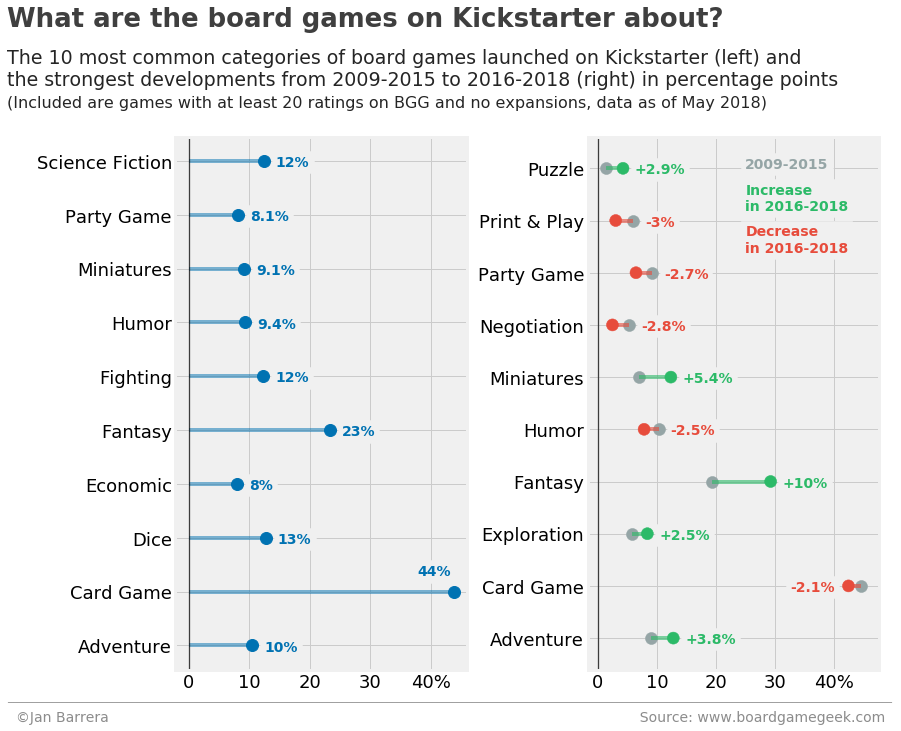

In [13]:
plt.figure(figsize=(12,8))
axes = []

### Left Plot ###

# Plotting the top categories
blue = [0, 114/255, 178/255]
ax1 = plt.subplot(1, 2, 1)
axes.append(ax1)

best_categories = ks_category_df.sort_values("percentage", ascending=False)[0:10].sort_values("name")
ax1.hlines(y=best_categories["name"], xmin=0, xmax=best_categories['percentage'], color=blue, alpha=0.5)
ax1.plot(best_categories['percentage'], best_categories["name"], "o", color=blue, markersize=12)

# Annotations for the top categories
diff = 2
for i, index in enumerate(best_categories.index):
    value = best_categories.loc[index]["percentage"]
    if best_categories.loc[index]["name"] == "Card Game":
        ax1.text(value - 3*diff, i+0.3, '{0:.2g}%'.format(value), fontsize=14, color=blue, weight="bold", backgroundcolor="#f0f0f0")
    else:
        ax1.text(value + diff, i-0.1, '{0:.2g}%'.format(value), fontsize=14, color=blue, weight="bold", backgroundcolor="#f0f0f0")

### Right Plot ###
        
# Plotting the top differences
color_before = "#95a5a6"
color_increase = "#2cba68"
color_decrease = "#e74c3c"
ax2 = plt.subplot(1, 2, 2)
axes.append(ax2)

color_after = []
top_ten_differences_df = kickstarter_before_and_after_df.sort_values("percentage_abs_diff", ascending=False)[0:10].sort_values("name")

for index in top_ten_differences_df.index:
    value_before = top_ten_differences_df.loc[index]["percentage_before"]
    value_after = top_ten_differences_df.loc[index]["percentage"]
    if value_after > value_before:
        color_after.append(color_increase)
    else:
        color_after.append(color_decrease)

ax2.hlines(y=top_ten_differences_df["name"], xmin=top_ten_differences_df['percentage_before'], xmax=top_ten_differences_df['percentage'], color=color_after, alpha=0.6)
ax2.scatter(top_ten_differences_df['percentage_before'], top_ten_differences_df["name"], color=color_before, alpha=1, s=144)
ax2.scatter(top_ten_differences_df['percentage'], top_ten_differences_df["name"], color=color_after, alpha=1 , s=144)

# Annotations for the top differences
diff = 2
for i, index in enumerate(top_ten_differences_df.index):
    value_before = top_ten_differences_df.loc[index]["percentage_before"]
    value_after = top_ten_differences_df.loc[index]["percentage"]
    if top_ten_differences_df.loc[index]["name"] == "Card Game":
        min_value = value_before
        pos = min_value - 6*diff
        text_value = "-{0:.2g}%".format(top_ten_differences_df.loc[index]["percentage_abs_diff"])
        color = color_decrease
    elif value_after > value_before:
        max_value = value_after
        pos = max_value + diff
        text_value = "+{0:.2g}%".format(top_ten_differences_df.loc[index]["percentage_abs_diff"])
        color = color_increase
    else:
        max_value = value_before
        pos = max_value + diff
        text_value = "-{0:.2g}%".format(top_ten_differences_df.loc[index]["percentage_abs_diff"])
        color = color_decrease
    ax2.text(pos, i-0.1, text_value, fontsize=14, color=color, weight="bold", backgroundcolor="#f0f0f0")
ax2.text(25, 9, "2009-2015", fontsize=14, color=color_before, weight="bold", backgroundcolor="#f0f0f0")
ax2.text(25, 8.2, "Increase\nin 2016-2018", fontsize=14, color=color_increase, weight="bold", backgroundcolor="#f0f0f0")
ax2.text(25, 7.4, "Decrease\nin 2016-2018", fontsize=14, color=color_decrease, weight="bold", backgroundcolor="#f0f0f0")

# Axis Settings
for index, ax in enumerate(axes):
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)
    ax.tick_params(axis="both", which="major", labelsize=18)
    ax.axvline(x=0, color="black", linewidth=1.3, alpha=0.7)
ax1.set_xticklabels([-10, 0, 10, 20, 30, "40%"])
ax2.set_xticklabels([-10, 0, 10, 20, 30, "40%"])
plt.tight_layout()  # To prevent overlap

# Title and subtitle
ax1.text(x=-30, y=11.5, s="What are the board games on Kickstarter about?", fontsize=26, weight="bold",
       alpha=0.75)
ax1.text(x=-30, y=10, s="The 10 most common categories of board games launched on Kickstarter (left) and\n" +
         "the strongest developments from 2009-2015 to 2016-2018 (right) in percentage points\n",
         fontsize=19, alpha=0.85)
ax1.text(x=-30, y=10, s="(Included are games with at least 20 ratings on BGG and no expansions, data as of May 2018)",
         fontsize=16, alpha=0.85)


# Signature bar
ax1.text(x=-30, y=-1, s="_________________________________________________________________________________________________________________________________________________________________________________",
       color="grey", alpha=0.9)
ax1.text(x=-30, y=-1.4, s="  ©Jan Barrera                                                                                                                      Source: www.boardgamegeek.com  ",
       fontsize=14, color="grey", alpha=0.9)
